In [31]:
# import libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import scipy.stats as stats

In [32]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')

# CORREÇÃO 1: Adicione .copy() aqui para garantir que o Pandas crie um novo objeto
# limpo na memória, desconectado do original.
data = data[data['total sulfur dioxide'] < 200].copy()

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# CORREÇÃO 2: Forma correta de criar a coluna booleana sem "Chained Assignment".
# Em vez de criar zeros e depois substituir, fazemos a lógica direto.
# O .astype(int) converte True para 1 e False para 0.
data['boolQuality'] = (data['quality'] > 5).astype(int)

labels = data['boolQuality']
data.drop('boolQuality', axis=1, inplace=True)
data.drop("quality", axis=1, inplace=True)


data_tensor = torch.tensor(data.to_numpy(), dtype=torch.float32)
labels_tensor = torch.tensor(labels.to_numpy(), dtype=torch.float32)[:, None]

X_train, X_test, y_train, y_test = train_test_split(data_tensor, labels_tensor, test_size=.2)

datasetTrain = TensorDataset(X_train, y_train)
datasetTest = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(datasetTrain, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(datasetTest, batch_size=datasetTest.tensors[0].shape[0])

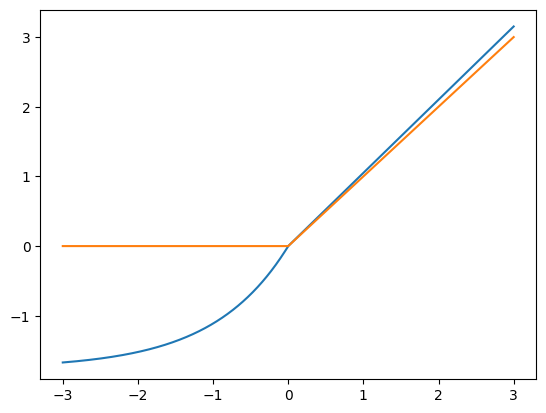

In [33]:
x = torch.linspace(-3,3, 1000)
plt.plot(x.detach(), torch.selu(x).detach())
plt.plot(x.detach(), torch.relu(x).detach())


In [34]:
class ANN(nn.Module):
    def __init__(self, actfun):
        super().__init__()
        self.input = nn.Linear(11,16)
        
        self.fc1 = nn.Linear(16,64)
        self.fc2 = nn.Linear(64,32)
        
        self.output = nn.Linear(32,1)
        
        self.actfun = actfun
    
    def forward(self,x):
        actfun = getattr(torch, self.actfun)
        x = actfun(self.input(x))
        x = actfun(self.fc1(x))
        x = actfun(self.fc2(x))
        return self.output(x)
    
        

In [35]:

def trainModel(ann, lossfun, optimizer):
    trainAcc = []
    testAcc = []
    losses = []
    
    for epoch in range(1000):
        batchAcc = []
        batchLoss = []
        ann.train()
        for X,y in train_loader:
            y_pred = ann(X)
            
            loss = lossfun(y_pred,y)
            
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchAcc.append(100*(torch.mean(((y_pred>0) == y).float())).item())
            batchLoss.append(loss.item())
            
            
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))
        ann.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            y_pred = ann(X)
            
        testAcc.append(100*(torch.mean((((y_pred>0) == y).float()))).item())
        
    return trainAcc, testAcc, losses

In [36]:
net = ANN("sigmoid")
net(torch.randn(10,11)).shape

torch.Size([10, 1])

In [37]:
activation_funs = ["relu", 'tanh', 'sigmoid', 'selu']

trainByAct = []
testByAct = []
losses = []

for index, actfun in enumerate(activation_funs):
    net = ANN(actfun)
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    train, test, loss = trainModel(net, lossfun, optimizer)
    trainByAct.append(train)
    testByAct.append(test)
    losses.append(loss)

In [38]:
train = np.array(trainByAct)
test = np.array(testByAct)
loss = np.array(losses)

In [ ]:
nn.sel

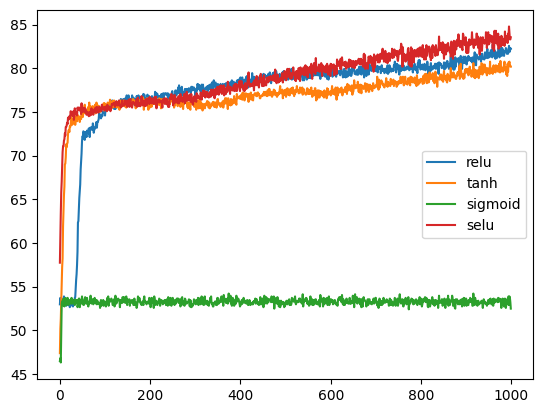

In [39]:
plt.plot(train.T)
plt.legend(activation_funs)

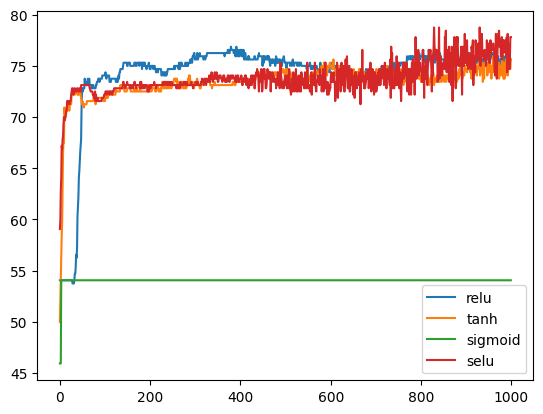

In [40]:
plt.plot(test.T)
plt.legend(activation_funs)

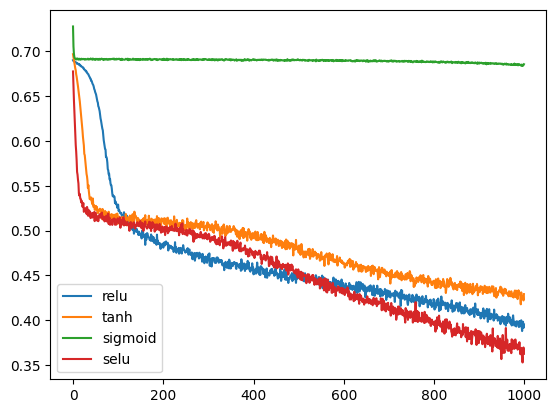

In [41]:
plt.plot(loss.T)
plt.legend(activation_funs)